In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
%matplotlib inline

<h2>Sample train & test data</h2>

In [2]:
# PAGE 16. First we generated 10 means mk from a bivariate Gaussian
#          distribution N((1,0),I) and labeled this class BLUE.
blue_means = np.array([[-0.769,  0.684], [ 1.315, -0.015], 
                       [-0.799, -1.253], [ 0.127, -1.590], 
                       [ 0.474,  0.463], [ 1.449, -1.250],
                       [ 0.385,  1.098], [ 0.796, -0.468], 
                       [ 0.145, -0.212], [ 1.631,  1.501]])
# PAGE 16. Similarly, 10 more were drawn from N((0,1),I) and labeled class ORANGE.
brown_means = np.array([[-0.622,  0.715], [ 0.828, 0.576], 
                        [ 0.349,  1.380], [ 2.735, 1.507], 
                        [-1.229,  1.447], [ 0.743, 1.470],
                        [-1.556,  1.171], [ 1.011, 0.073], 
                        [-1.362,  1.199], [-0.814, 1.321]])

In [3]:
# PAGE 16. Then for each class we generated 100 observations as follows: 
#          for each observation, we picked an mk at random with probability 1/10, 
#          and then generated a N(mk,I/5), thus leading to a mixture of Gaussian 
#          clusters for each class.
def sample(n):
    means = np.vstack((blue_means, brown_means))
    # we'll use GaussianMixture from sklearn.mixture for random sampling 
    gm = GaussianMixture(n_components=20, covariance_type='spherical', means_init=means)
    # fitting 20 spherical components to means and setting cov to 1/5
    gm.fit(means)
    gm.covariances_ = [1/5]*20
    X, y = gm.sample(n) # y is the component's index
    y = 1*(y>=10)       # when the index < 10, then point is BLUE (0)
    return X, y

# sample train for model optimization
X_train, y_train = sample(200)
# sample test for accuracy score calculation
X_test, y_test = sample(10000)

<h2>Prepare Plotting Functions</h2>

In [4]:
# define blue and orange colors
BLUE, ORANGE, GRAY1, GRAY4, BLUE1 = '#57B5E8', '#E69E00', '#231F20', '#646369', '#174A7E'
# configure plot font family to Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5

In [5]:
# draws train data scatter plot with title
def plot_train_data(title):
    fig, ax1 = plt.subplots(figsize=(3.35, 3.1), dpi=110)
    ax1.set_aspect('equal')
    ax1.scatter(X_train[:,0], X_train[:,1], s=18, facecolors='none', 
                edgecolors=np.array([BLUE, ORANGE])[y_train])
    ax1.tick_params(bottom=False, left=False, 
                    labelleft=False, labelbottom=False)
    ax1.set_xlim(-2, 3)
    ax1.set_ylim(-2, 3)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    ax1.text(-2, 3.2, title, color=GRAY4, fontsize=10)
    for spine_name in ['top', 'left', 'right', 'bottom']:
        ax1.spines[spine_name].set_color(GRAY1)
    return fig, ax1

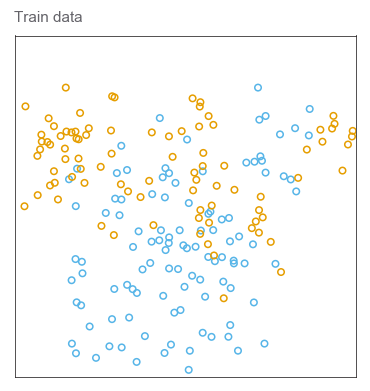

In [6]:
_, _ = plot_train_data('Train data')

In [7]:
# given prediction function calculates X points on n x n grid
# and corresponding predicted classes for ploting background dots
def predict_grid(n, predict_function):
    vals = np.linspace(-2, 3, n)
    X = np.transpose([np.tile(vals, n), np.repeat(vals, n)])
    y = predict_function(X)
    return X, y

# given prediction function calculates X0 and X1 n x n meshgrids
# and corresponing predicted classes meshgrid for plotting decision boundary
def predict_meshgrid(n, predict_function):
    X, y = predict_grid(n, predict_function)
    return X[:,0].reshape(n, n), X[:,1].reshape(n, n), y.reshape(n, n)

# plots train data, model decision bounary (by it's predict function) 
# and background points
def plot_model(predict_function, title):
    fig, ax1 = plot_train_data(title)
    # plot background dots
    X, y = predict_grid(81, predict_function)
    ax1.scatter(X[:,0], X[:,1], marker='.', lw=0, s=2, 
                c=np.array([BLUE, ORANGE])[y])
    # plot decision boundary
    X0, X1, Y = predict_meshgrid(1000, predict_function)
    ax1.contour(X0, X1, Y, [0.5], colors=GRAY1, linewidths=[0.7])
    return fig, ax1

<h2>Calculate Bayes Error and the Optimal Bayes Decision Boundary</h2>

In [8]:
# having known all means and convariances we build an optimal Bayes classifier
def optimal_bayes_predict(X):
    cov = np.eye(2)/5
    # convert means to frozen random variables for pdf calculation
    blue_rvs = [multivariate_normal(blue_means[i], cov) for i in range(10)]
    brown_rvs = [multivariate_normal(brown_means[i], cov) for i in range(10)]
    p_blue = np.sum(np.array([rv.pdf(X) for rv in blue_rvs]), axis=0)
    p_brown = np.sum(np.array([rv.pdf(X) for rv in brown_rvs]), axis=0)
    y_hat = 1*(p_brown>p_blue)
    return y_hat

In [9]:
# calculate the optimal Bayes error rate on the test data
bayes_error_rate = mean_absolute_error(y_test, optimal_bayes_predict(X_test))
print(f'The optimal Bayes error rate = {bayes_error_rate}')

The optimal Bayes error rate = 0.2151


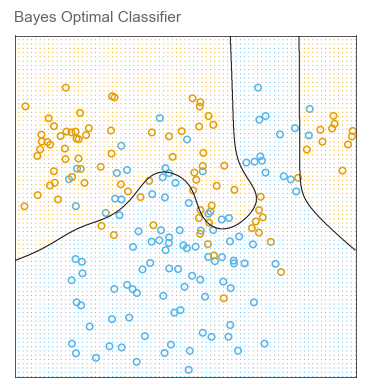

In [10]:
# test prepare_model_plot for the optimal Bayes
_, _ = plot_model(optimal_bayes_predict, 'Bayes Optimal Classifier')

<h2>More Plotting Functions</h2>

In [11]:
# save Bayes meshgrids for optimal decision boundary plotting
X0_bayes, X1_bayes, Y_bayes = predict_meshgrid(1000, optimal_bayes_predict)

# plot model with background Bayes optimal decision boundary and stat
def plot_model_detailed(predict_function, title):
    fig, ax1 = plot_model(predict_function, title)
    ax1.contour(X0_bayes, X1_bayes, Y_bayes, [0.5], colors='purple', 
                linewidths=[0.5], linestyles='dashed')
    test_error_rate = mean_absolute_error(y_test, predict_function(X_test))
    train_error_rate = mean_absolute_error(y_train, predict_function(X_train))    
    parms = {'color': GRAY1, 
             'fontsize': 8, 
             'bbox': {'facecolor': 'white', 'pad': 5, 'edgecolor': 'none'}}
    l1 = f'Training Error: {train_error_rate:.3f}'
    l2 = f'Test Error:       {test_error_rate:.3f}'
    l3 = f'Bayes Error:    {bayes_error_rate:.3f}'
    ax1.text(-1.85, -1.35, l1, **parms)
    ax1.text(-1.85, -1.60, l2, **parms)
    ax1.text(-1.85, -1.85, l3, **parms)
    return fig, ax1    

<h2>Linear Regression</h2>

In [12]:
from sklearn.linear_model import LinearRegression

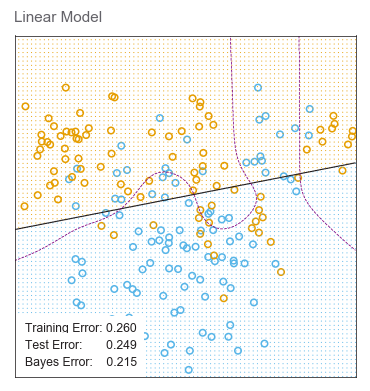

In [13]:
# PAGE 12. Let’s look at an example of the linear model in a classiﬁcation context. 
reg = LinearRegression().fit(X_train, y_train)

# PAGE 12. The ﬁtted values Y-hat are converted to a ﬁtted class variable G-hat according to the rule
#          G-hat =(ORANGE if Y-hat > 0.5, BLUE if Y-hat ≤ 0.5.
def linear_predict(X):
    return 1*(reg.predict(X)>0.5)

# PAGE 13. The line is the decision boundary deﬁned by x.T @ b = 0.5. The orange shaded region denotes
#          that part of input space classiﬁed as ORANGE, while the blue region is classiﬁed as BLUE. 
_, _ = plot_model_detailed(linear_predict, 'Linear Model')

<h2>Nearest-Neighbor Methods</h2>

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [15]:
# use GridSearchCV to find best parameter n_neighbors 
# through 10-folds cross-validation 
# will not use this value to be consistent with the book
parameters = {'n_neighbors': list(range(1, 50))}
knc = KNeighborsClassifier(n_neighbors=1)
grid = GridSearchCV(knc, parameters, cv=10)
grid.fit(X_train, y_train)
# sometimes it equals to 15
grid.best_params_

C:\Python64\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_neighbors': 5}

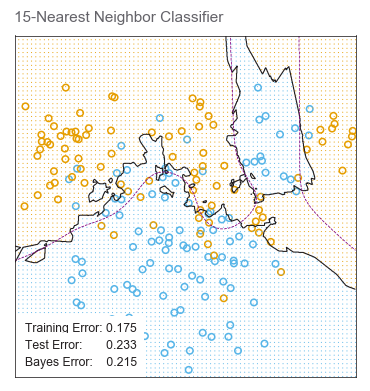

In [16]:
# PAGE 14. use 15-nearest-neighbor averaging of the binary coded response as the method of ﬁtting. 
#          Thus Y-hat is the proportion of ORANGE’s in the neighborhood, and so assigning class ORANGE 
#          to G-hat if Y-hat > 0.5 amounts to a majority vote in the neighborhood.
knc = KNeighborsClassifier(n_neighbors=15).fit(X_train, y_train)
_, _ = plot_model_detailed(knc.predict, '15-Nearest Neighbor Classifier')

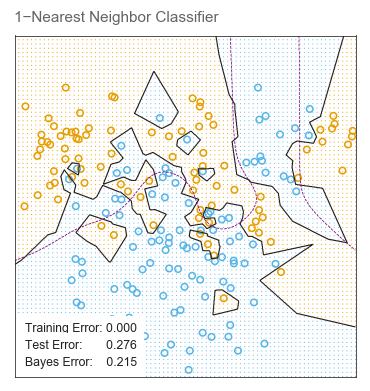

In [17]:
# PAGE 16. The classes are coded as a binary variable (BLUE = 0,ORANGE = 1), 
#          and then predicted by 1-nearest-neighbor classiﬁcation.
knc = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
_, _ = plot_model_detailed(knc.predict, '1−Nearest Neighbor Classifier')

<h2>Logistic Regression with Natural Cubic Spline Basis Expansion</h2>

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [19]:
# sklearn doesn't have natural cubic spline basis expansion
# so, let's implement it with fit-transform method to be used
# in pipeline
class NaturalCubicSplineFeatures():
    def __init__(self, knots, tensor_product=False):
        self.knots = knots
        self.tensor_product=tensor_product
    
    @staticmethod
    def dk(x, xi_k, xi_K):
        return (max(0, x-xi_k)**3) / (xi_K-xi_k)
    
    @staticmethod
    def do_nc_expansion(x, xis):
        X = np.zeros(shape=(x.shape[0], len(xis)))
        for i in range(X.shape[0]):
            X[i, 0] = 1
            X[i, 1] = x[i]
            for k in range(2, len(xis)):
                X[i, k] = NaturalCubicSplineFeatures.dk(x[i], xis[k-2], xis[-1]) - \
                          NaturalCubicSplineFeatures.dk(x[i], xis[-2], xis[-1])
        return X
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        h = []
        for i in range(X.shape[1]):
            h.append(NaturalCubicSplineFeatures.do_nc_expansion(X[:,i], self.knots[i])[:,1:])            
        if self.tensor_product:
            for j in range(h[0].shape[1]):
                for k in range(h[1].shape[1]):
                    h.append(h[0][:,j:j+1]*h[1][:,k:k+1])
        result = np.hstack(h)
        return result

In [32]:
# the book doesn't give knots positions
knots = np.array([-2, 0, 1, 3])

C:\Python64\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


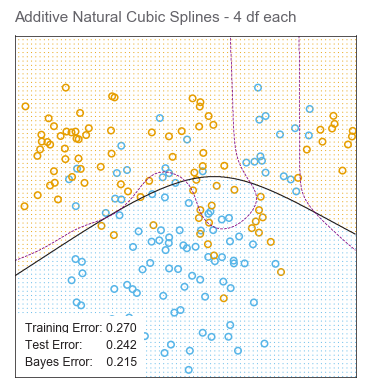

In [33]:
# PAGE 164. The upper panel shows the decision boundary of an additive 
#           logistic regression model, using natural splines in each 
#           of the two coordinates (total df = 1 + (4−1) + (4−1) = 7).
model = Pipeline([('expand', NaturalCubicSplineFeatures([knots, knots], 
                                                      tensor_product=False)),
                  ('logistic', LogisticRegression())])
lrc = model.fit(X_train, y_train)
_, _ = plot_model_detailed(lrc.predict, 'Additive Natural Cubic Splines - 4 df each')
# TODO: check implementation, the training error should be better than without expansion

C:\Python64\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


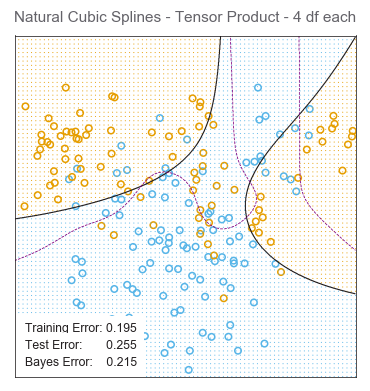

In [34]:
# PAGE 164. The lower panel shows the results of using a tensor product 
#           of natural spline bases in each coordinate (total df = 4 × 4 = 16).
model = Pipeline([('expand', NaturalCubicSplineFeatures([knots, knots], 
                                                      tensor_product=True)),
                  ('logistic', LogisticRegression())])
lrc = model.fit(X_train, y_train)
_, _ = plot_model_detailed(lrc.predict, 'Natural Cubic Splines - Tensor Product - 4 df each')

In [35]:
import tensorflow as tf
import math
from sklearn.preprocessing import StandardScaler, OneHotEncoder

C:\Python64\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [36]:
scaler = StandardScaler().fit(X_train)
X_train_standartized = scaler.transform(X_train)
Y_train_one_hot = OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).toarray()
session = tf.Session()

C:\Python64\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [37]:
n_hidden = 10
initializer = tf.contrib.layers.xavier_initializer()

x = tf.placeholder(tf.float64, shape=[None, 2])
y = tf.placeholder(tf.float64, shape=[None, 2])

# variables to be optimized with initial guess
A = tf.Variable(initializer([2, n_hidden], dtype=tf.float64))
a0 = tf.Variable(initializer([1, n_hidden], dtype=tf.float64))
Z = tf.nn.sigmoid(a0 + x@A)

B = tf.Variable(initializer([n_hidden, 2], dtype=tf.float64))
b0 = tf.Variable(initializer([2], dtype=tf.float64))

T = b0 + Z@B

y_hat = tf.nn.softmax(T)
cross_entropy = y*tf.log(y_hat)
loss = tf.reduce_mean(-tf.reduce_sum(cross_entropy, reduction_indices = 1))

Instructions for updating:
Use the retry module or similar alternatives.


In [38]:
feed_dict = {x: X_train_standartized, 
             y: Y_train_one_hot}

In [39]:
adm = tf.train.AdamOptimizer(1e-2).minimize(loss)
#adm = tf.contrib.opt.AdamWOptimizer(0.002, learning_rate=1e-2).minimize(loss)
session.run(tf.global_variables_initializer())

In [40]:
session.run(loss, feed_dict)

1.1292962291538158

In [43]:
step = 0
# calc initial loss
current_loss = session.run(loss, feed_dict)
while step < 100000:
    step += 1
    if math.log(step, 2).is_integer():
        print(f'step: {step}, current loss: {current_loss}')
    session.run(adm, feed_dict)
    current_loss = session.run(loss, feed_dict)
print(f'ENDED ON STEP: {step}, FINAL LOSS: {current_loss}')

step: 1, current loss: 0.1744885502937411
step: 2, current loss: 0.1744885438665621
step: 4, current loss: 0.17448853100291437
step: 8, current loss: 0.17448850523840964
step: 16, current loss: 0.17448845356020948
step: 32, current loss: 0.17448834960441373
step: 64, current loss: 0.17448813927395992
step: 128, current loss: 0.1744877087662097
step: 256, current loss: 0.17448687698601031
step: 512, current loss: 0.1744852803097848
step: 1024, current loss: 0.17448203285267552
step: 2048, current loss: 0.174521904723587
step: 4096, current loss: 0.1744632528723882
step: 8192, current loss: 0.17443979842433177
step: 16384, current loss: 0.1743973225754597
step: 32768, current loss: 0.1743266696972907
step: 65536, current loss: 0.17422317920249256
ENDED ON STEP: 100000, FINAL LOSS: 0.17414609942990733


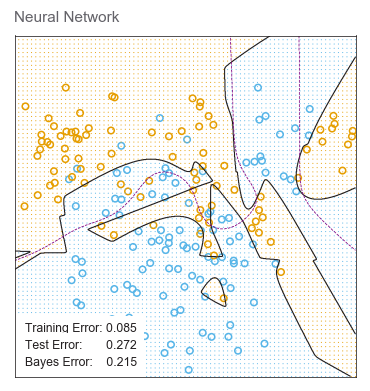

In [42]:
def nn_predict(X):
    X = scaler.transform(X)
    return np.argmax(session.run(y_hat, {x: X}), axis=1)
_, _ = plot_model_detailed(nn_predict, 'Neural Network')